## Basic MF model
After getting subset of data, which we can compute in limited time and large enough for prediction, the first model we use is the basic SVD model. Officially this model is stated as:

$${R}_{i,x}=\mu + b_i + b_x + U_i^T \dot V_x$$

here, we get*U* and *V* from:

$$Min_{U,V} \sum ((r_{i,x}-R_{i,x})^2 + \lambda ||U||^2 +\lambda ||V||^2)$$

$r_{i,x}$ is the training data, $R_{i,x}$ is the prediction data, $\lambda$ is the regularization parameter.

The dimention of $U$ is (#users, $k$), $V$ is (#restaurants, $k$), here $k$ is number of laten factors. To determine the proper $k$ for basic model, the following code is programmed and shows the best $k$ for basic model is 30, which is big enough to minimize the RMSE of the training data and minimizes the possible computation assumption; The regularization parameter $\lambda$ is 0.001

In the following code, function *optimized_matrix_factorization* is the one used for SVD computation. In the graph 'RMSE variance along with k', we can see that when k reaches 30, the decreasing of RMSE becomes slow, so 30 is chosen for k, when $\lambda=0.001$. For other $\lambda$, such as 0.0005, the result is similar.

In [1]:
#defines svd function 'optimized_matrix_factorization' and rmse calulation function 'rmse_cal'

import numpy as np
import matplotlib.pyplot as plt
import math

o = open('../new_5k/rating_subset_training.data', 'r').read()
rating = eval(o)

#naive python one
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in xrange(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in xrange(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
    return P, Q.T

def optimized_matrix_factorization(R, P, Q, K, none_zero, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        eR = np.dot(P,Q);
        e = 0;
        for p in none_zero:
            i=p[0];
            j=p[1];
            e = e + pow(R[i][j] - eR[i][j], 2)
            for k in xrange(K):
                e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        for p in none_zero:
            i=p[0];
            j=p[1];
            eij = R[i][j] - eR[i][j]
            for k in xrange(K):
                P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
    return P, Q.T

def rmse_cal(R,P,Q,none_zero,num):
    Q=Q.T;
    r=np.dot(P,Q);
    error=0;
    for p in none_zero:
        i=p[0];
        j=p[1];
        error+=(R[i][j]-r[i][j])*(R[i][j]-r[i][j]);
    error=math.sqrt(error/num);
    return error;

In [2]:
#this is the example of how 'optimized_matrix_factorization' works. R is the rating, P, Q is U, V respectly.
#K is the number of laten factors, as we can see, after 200 steps, the prediction value becomes close to the actual value
#(only none zero ones)

R = [[5,3,0,1],[4,0,0,1],[1,1,0,5],[1,0,0,4],[0,1,5,4],]

R = np.array(R)

N = len(R)
M = len(R[0])
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K,200, 0.001)
print np.dot(nP,nQ.T)

[[ 4.34071917  1.76080518  4.11817495  2.16890375]
 [ 3.29842454  1.28610635  3.02198754  1.39860944]
 [ 1.85209037  1.38353268  3.06476553  3.96510281]
 [ 1.43091089  1.18223583  2.60220885  3.60827461]
 [ 3.98129182  1.98835937  4.5493724   3.78433826]]


In [3]:
#find out the none zero positions and bx, bi, \mu, in the equation of the basic mf model
#get the rate matrix 'ratemat'

from timeit import default_timer as timer

user=[];
item=[];
user2idx={};
item2idx={};
countuser=0;
countitem=0;
total=0.;

num=1000;
steps=200;  #the computation steps
begin=2;
end=61;
none_zero=[];
for rate in rating[0:num]:
    total+=rate[3];
    if rate[1] in user2idx:
        useridx=user2idx[rate[1]];
        uni=user[useridx];
        uni[0]+=rate[3];
        uni[1]+=1.;
        user[useridx]=uni;
    else:
        uni=[];
        uni.append(0.);
        uni.append(1.);
        uni[0]+=rate[3];
        user.append(uni);
        user2idx[rate[1]]=countuser;
        countuser+=1;
    if rate[2] in item2idx:
        itemidx=item2idx[rate[2]];
        uni=item[itemidx];
        uni[0]+=rate[3];
        uni[1]+=1.;
        item[itemidx]=uni;
    else:
        uni=[];
        uni.append(0.);
        uni.append(1.);
        uni[0]+=rate[3];
        item.append(uni);
        item2idx[rate[2]]=countitem;
        countitem+=1;
        
for x in xrange(countuser):
    user[x][0]/=user[x][1];
    
for i in xrange(countitem):
    item[i][0]/=item[i][1];
    
miu=total/num;
ratemat=np.zeros((countuser,countitem));
for rate in rating[0:num]:
    useridx=user2idx[rate[1]];
    itemidx=item2idx[rate[2]];
    none_zero.append([useridx,itemidx]);
    ratemat[useridx][itemidx]=rate[3]#-(user[useridx][0]+item[itemidx][0]-miu);

finished in 554.645543 s


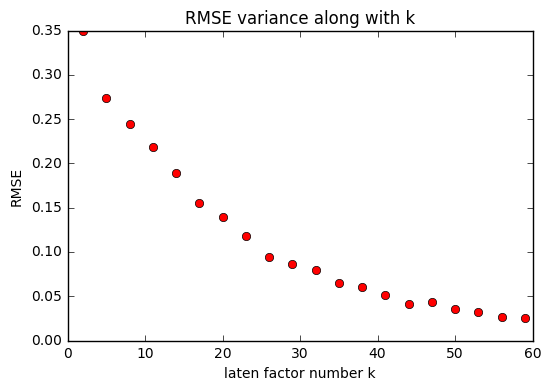

In [4]:
#choose K, when regularization is 0.001
#for each k, process SVD and calculate the rmse 

start = timer()
rmse=[];
k=begin;
K=[];
while k <=end:
    P = np.random.rand(countuser,k);
    Q = np.random.rand(countitem,k);
    nP, nQ = optimized_matrix_factorization(ratemat, P, Q, k,none_zero, steps, 0.001)
    #nP, nQ = matrix_factorization(ratemat, P, Q, k, steps, 0.001)
    error=rmse_cal(ratemat,nP,nQ,none_zero,num);
    rmse.append(error);
    K.append(k);
    k+=3;
    
dt = timer() - start
print "finished in %f s" % dt

plt.plot(K, rmse, 'ro');
plt.xlabel('laten factor number k')
plt.ylabel('RMSE')
plt.title('RMSE variance along with k')
plt.show();

finished in 1225.350046 s


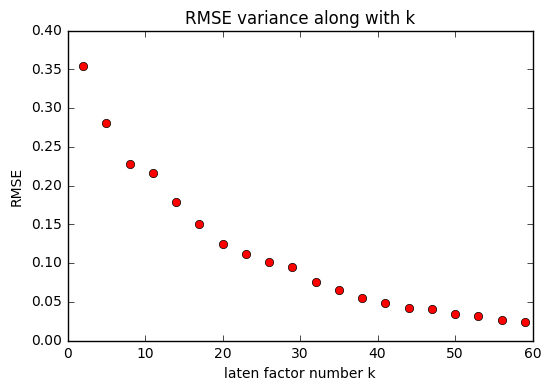

In [6]:
#choose K, when regularization is 0.0001
#for each k, process SVD and calculate the rmse
#as we can see, the RMSE is really bad when regularization is 0.0005

start = timer()
rmse=[];
k=begin;
K=[];
while k <=end:
    P = np.random.rand(countuser,k);
    Q = np.random.rand(countitem,k);
    nP, nQ = optimized_matrix_factorization(ratemat, P, Q, k,none_zero, 400, 0.0005)
    #nP, nQ = matrix_factorization(ratemat, P, Q, k, steps, 0.001)
    error=rmse_cal(ratemat,nP,nQ,none_zero,num);
    rmse.append(error);
    K.append(k);
    k+=3;
    
dt = timer() - start
print "finished in %f s" % dt

plt.plot(K, rmse, 'ro');
plt.xlabel('laten factor number k')
plt.ylabel('RMSE')
plt.title('RMSE variance along with k')
plt.show();

In [7]:
#if steps=100, rate=0.01, num=100,  25 is best for k
#if steps=200, rate=0.001, num=500, 30 is best for k
#if steps=200, rate=0.001, num=1000, 30 or 40 is best for k

#use k as 30, regularization parameter is 0.001 do n-fold to see the performance
def performance(P, Q, R, none_zero):
    num=len(none_zero)
    Q=Q.T;
    r=np.dot(P,Q);
    error=0;
    for p in none_zero:
        i=p[0];
        j=p[1];
        error+=(R[i][j]-r[i][j])*(R[i][j]-r[i][j]);
        #print R[i][j]-r[i][j]
    error=math.sqrt(error/num);
    return error;
    
n=10;
testnum=num*0.1;
times=5;
total=len(none_zero);
k=30;
rmse=0.;

for x in xrange(times):
    chose=np.random.randint(0,total,size=testnum);
    not_chose=list(set(range(0,total))-set(chose));
    trainmat = np.copy(ratemat)
    train_none_zero=list(none_zero[i] for i in not_chose);
    for p in chose:
        i=none_zero[p][0];
        j=none_zero[p][1];
        trainmat[i][j]=0;
    test_none_zero=list(none_zero[i] for i in chose);
    P = np.random.rand(countuser,k);
    Q = np.random.rand(countitem,k);
    nP, nQ = matrix_factorization(trainmat, P, Q, k, steps, 0.001);
    #nP, nQ = changed_matrix_factorization(ratemat, P, Q, k, train_none_zero, steps, 0.01);
    rmse+=performance(nP,nQ,ratemat,train_none_zero);
    
print rmse/times;

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.0800008837717


## Social MF
### why social mf:
The pervasive usage of social media allows users to participate in online activities which produce a large amount of social relations such as trust relations in Epinions. Users in the physical world are likely to ask for suggestions from their local friends while they also tend to seek suggestions from users with high global reputations, indicating both local and global views of social relations can be potentially exploited to improve the performance of online recommender systems.
### how social mf:
*exploiting local social context:*
Users with similar tastes are more likely to be socially connected, and social influence suggests that users that are socially connected are more likely to share similar tastes. However, the low cost of social relation formation can lead to social relations with heterogeneous strengths. Since users with strong ties are more likely to share similar tastes than those with weak ties, treating all social relations equally is likely to lead to degradation in recommendation performance. We should
consider heterogeneous strengths when exploiting local social context for recommendation. We simply use the rating cosine similarity to measure the social relation strength. The local social model is below:

$$Min_{U,H} \sum_{i=1}^n \sum_{U_k \in N_i} (S_{i,k}-U_i^THU_k)^2$$

Here $U$ is the similar one in basic model. $H$ is the importance matrx. $S_{i,k}$ is the cosine similarity of user $i$, $k$, $N_i$ is the list of friends of user $i$
*exploiting global social context:*
user reputation plays an important role in recommendation and many companies employ people with high reputations to enhance consumers’ awareness and understanding of their products. Suggestions from people with high reputations positively affect a consumer’s adoption of a brand. Hence, global model is below:

$$Min_{U,V} \sum_{i,x} w_i (R_{i,x}-U_i^T V_x)^2$$

Here, $w_i$ indicates the importance of a user, Page rank is a brilliant way to calculate the importance of pages, similarly, we can apply it into the social graph and compute the importance of users. $w_i$ can be defined as:

$$w_i=\frac{1}{1+log(r_i)}$$

Here, $r_i$ is the page rank order of user $i$.

*combination of global and local context:*

$$Min_{U,H,V} \sum_{i,x} w_i (R_{i,x}-U_i^T V_x)^2 + \sum_{i=1}^n \sum_{U_k \in N_i} (S_{i,k}-U_i^THU_k)^2$$

In [2]:
f1 = open('../5k-data/review_5k_user', 'r').read()
review_5k_user = eval(f1)

f2 = open('../5k-data/review_5k_business', 'r').read()
review_5k_business = eval(f2)

f3 = open('../5k-data/review_5k_rating', 'r').read()
review_5k_rating = eval(f3)

f4 = open('../5k-data/relation_5k', 'r').read()
relation_5k = eval(f4)

In [3]:
#define the function of SVD and performance calculation

import math
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
import networkx as nx
import matplotlib.pyplot as plt
from time import time

def social_matrix_factorization(R, P, Q, K, S, H, N, Si, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in xrange(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] * S[i][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] * S[i][j]- beta * Q[k][j])
            for m in N[i]:
                Eim=Si[i][m]-np.sum(P[i,:]*H*P[j,:]);
                for k in xrange(K):
                    P[i][k]=P[i][k]+alpha*(2 * Eim * beta * H[k] * P[m][k]);
                    H[k]=H[k]+ alpha*(2 * Eim * beta * P[i][k] * P[m][k]);
        eR = np.dot(P,Q)
        e = 0
        E= 0
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in xrange(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
            for m in N[i]:
                E = E + pow(Si[i][m]-np.sum(P[i,:]*H*P[j,:]),2);
        if e + E/2 < 0.001:
            break
    return P, Q.T, H

def performance(P, Q, R, none_zero):
    num=len(none_zero)
    Q=Q.T;
    r=np.dot(P,Q);
    error=0;
    for p in none_zero:
        i=p[0];
        j=p[1];
        error+=(R[i][j]-r[i][j])*(R[i][j]-r[i][j]);
        #print R[i][j]-r[i][j]
    error=math.sqrt(error/num);
    return error;

In [4]:
#calculate page rank score of the social graph Wij and similarity value Sij
num_user = 4929
num_business = 2686
num_review = 49486
Nij=[[]]*num_user;

for r in relation_5k:
    Nij[r[0]]=r[1];
    
row = np.array([])
col = np.array([])
val = np.array([])

Tij = csr_matrix((val,(row,col)), shape=(num_user,num_user)).toarray()
for u in relation_5k:
    for f in u[1]:
        Tij[u[0]][f] = 1
        
none_zero=[];
Rij = csr_matrix((val,(row,col)), shape=(num_user,num_business)).toarray()
for r in xrange(num_review):
    Rij[review_5k_user[r]][review_5k_business[r]] = review_5k_rating[r];
    none_zero.append([review_5k_user[r],review_5k_business[r]]);
    
#similarity calculation
Sij_norm = []
for u in xrange(num_user):
    Sij_norm.append(math.sqrt(np.dot(Rij[u], Rij[u])))
    
Sij = np.dot(Rij, Rij.T)

for i in xrange(num_user):
    for j in xrange(num_user):
        if Sij_norm[i] and Sij_norm[j]:
            Sij[i][j] = Sij[i][j]/Sij_norm[i]/Sij_norm[j]
        else:
            Sij[i][j]=0

import networkx as nx

node_list = []
for u in xrange(num_user):
    node_list.append(u)

#page rank
G=nx.Graph()
G.add_nodes_from(node_list)
for u in relation_5k:
    for f in u[1]:
        G.add_edge(u[0], f)
PR = nx.pagerank(G)

#page rank score Wij calculation
from operator import itemgetter
sorted_PR = sorted(PR.items(), key=itemgetter(1), reverse=True)
rank = {}
for u in xrange(num_user):
    rank[sorted_PR[u][0]] = u
Ri = []
for u in xrange(num_user):
    Ri.append(rank[u]+1)
Wij = csr_matrix((val,(row,col)), shape=(num_user,num_business)).toarray()
for i in xrange(num_user):
    for j in xrange(num_business):
        if Rij[i][j] > 0:
            Wij[i][j] = math.sqrt(Ri[i])

In [6]:
n=10;
testnum=num_review*0.1;
times=1;
total=len(none_zero);
k=8;
rmse=0.;
steps=10;
start=time();
true_times=0;
for x in xrange(times):
    chose=np.random.randint(0,total,size=testnum);
    not_chose=list(set(range(0,total))-set(chose));
    trainmat = np.copy(Rij)
    train_none_zero=list(none_zero[i] for i in not_chose);
    for p in chose:
        i=none_zero[p][0];
        j=none_zero[p][1];
        trainmat[i][j]=0;
    test_none_zero=list(none_zero[i] for i in chose);
    P = np.random.rand(num_user,k);
    Q = np.random.rand(num_business,k);
    H = np.random.rand(k)
    nP, nQ , nH= social_matrix_factorization(trainmat, P, Q, k, Wij, H, Nij, Sij, steps, 0.0002, 0.2);
    #nP, nQ = changed_matrix_factorization(ratemat, P, Q, k, train_none_zero, steps, 0.01);
    rmse+=performance(nP,nQ,Rij,test_none_zero);
    true_times+=1;
    if(time()-start>36):
        break;
    
print rmse/true_times;

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1.04159139513


## Topic MF

Firstly, the topics we obtain can explain the variation present in ratings and reviews.  Secondly, combining ratings with review text allows us to predict ratings more accurately than approaches that consider either of the two sources of data in isolation.

To get the topic distribution of reviews and words, LDA (Latent Dirichlet Allocation) is used. After the review-topic and word-topic distribution matrix. For a particular review, given the word-topic distribution $\phi$ and topic assignment for each word $z_{d,j}$, (topic assignment for word $j$ in review $d$) and the topic distribution $\theta$, the probability of a paticualar review is:

$$p(\Gamma|\theta,\phi,z)=\Pi_{d\in \Gamma} \Pi_{j=1}^{N_d} \theta _{z_{d,j}} \phi_{z_{d,j},w_{d,j}}$$

The Topic MF model is defined as:

$$Min_{U,V,\theta,z} \sum(r_{i,x}-R_{i,x})^2+\lambda p(\Gamma|\theta,\phi,z)$$

Here $\lambda$ is the regularization parameter for topic model, to prevent downflow, we use the format of $log$ likeliyhood:

$$Min_{U,V,\theta,z} \sum(r_{i,x}-R_{i,x})^2 - \lambda log(p(\Gamma|\theta,\phi,z))$$,

That is:

$$Min_{U,V,\theta,z} \sum(r_{i,x}-R_{i,x})^2 - \lambda \sum_{d\in \Gamma} \sum_{j=1}^{N_d}log(\theta _{z_{d,j}} \phi_{z_{d,j},w_{d,j}})$$,

For Topic model, a C++ program is used to evaluate, below is the python program to show the results of the C++ code

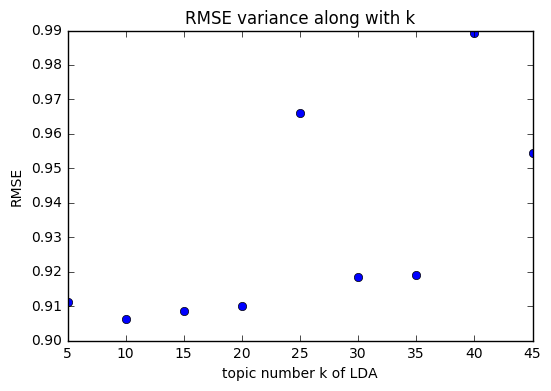

In [13]:
#regularization, lamda, K are the three parameters to be adjust in Topic Model

import math
import matplotlib.pyplot as plt

#regularization=0, lamda=0.1
#vary K

k=5;
K=[];
RM=[];
while k<=45:
    K.append(k);
    rmse=0.;
    n=0.;
    l=0;
    file="../code_RecSys13/rs/predictions_k="+str(k)+".out"
    f = open(file);
    for line in f.readlines():
        if l<44540:
            l+=1;
            continue;
        rs_list=line.split(' ');
        err=float(rs_list[2])-float(rs_list[3]);
        rmse+=err*err;
        n+=1;
    RM.append(math.sqrt(rmse/n));
    k+=5;

plt.plot(K,RM,'o');
plt.xlabel('topic number k of LDA')
plt.ylabel('RMSE')
plt.title('RMSE variance along with k')
plt.show();

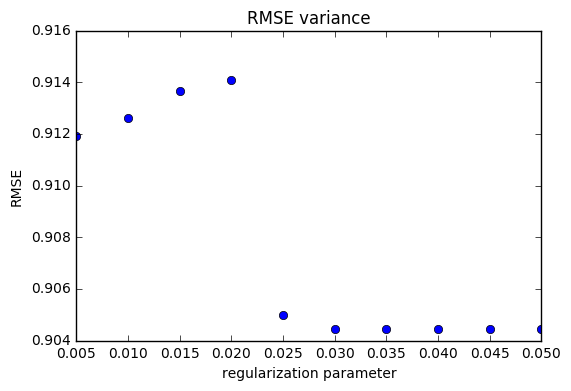

In [1]:
import math
import matplotlib.pyplot as plt

#K=5, lamda=0.1
#vary regularization

k=0.005;
K=[];
RM=[];
while k<=0.05:
    K.append(k);
    rmse=0.;
    n=0.;
    l=0;
    file="../code_RecSys13/rs/predictions_l="+str(k)+".out"
    f = open(file);
    for line in f.readlines():
        if l<44540:
            l+=1;
            continue;
        rs_list=line.split(' ');
        err=float(rs_list[2])-float(rs_list[3]);
        rmse+=err*err;
        n+=1;
    RM.append(math.sqrt(rmse/n));
    k+=0.005;

plt.plot(K,RM,'o');
plt.xlabel('regularization parameter')
plt.ylabel('RMSE')
plt.title('RMSE variance')
plt.show();

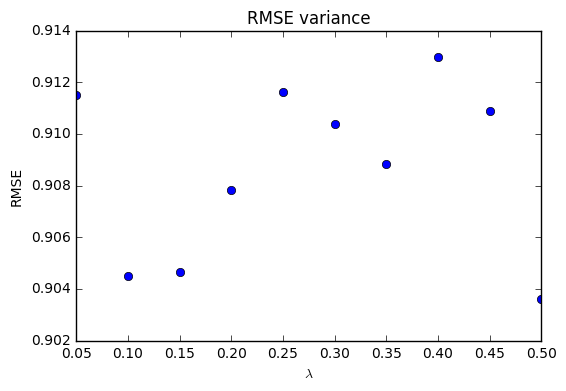

In [2]:
import math
import matplotlib.pyplot as plt

#K=5, regularization=0.035
#vary lamda

k=0.05;
K=[];
RM=[];
while k<=0.5:
    K.append(k);
    rmse=0.;
    n=0.;
    l=0;
    file="../code_RecSys13/rs/predictions_la="+str(k)+".out"
    f = open(file);
    for line in f.readlines():
        if l<44540:
            l+=1;
            continue;
        rs_list=line.split(' ');
        err=float(rs_list[2])-float(rs_list[3]);
        rmse+=err*err;
        n+=1;
    RM.append(math.sqrt(rmse/n));
    k+=0.05;

plt.plot(K,RM,'o');
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.title('RMSE variance')
plt.show();

In [3]:
#finally, lamda=0.1, reg=0.035, k=10

rmse=0.;
n=0.;
l=0;
file="../code_RecSys13/rs/predictions.out"
f = open(file);
for line in f.readlines():
    if l<44540:
        l+=1;
        continue;
    rs_list=line.split(' ');
    err=float(rs_list[2])-float(rs_list[3]);
    rmse+=err*err;
    n+=1;
print math.sqrt(rmse/n);

0.907157138867
